In [2]:
from mlsel.distributions import VariableLimitsPowerLaw, FixedLimitsTruncatedGaussian
from mlsel.nn.networks import LinearModel
from mlsel.nn.execute import train
from mlsel.nn.rescaling import ZScoreRescaler
import matplotlib.pyplot as plt
import numpy as np
import torch
%load_ext autoreload
%autoreload 2

device = "cpu"

In this example, we're going to learn an analytic SNR function and use it to model selection effects for a population of gravitational 
wave signals from compact binary coalescences. 

In reality, the SNR function is not analytic but our approach would be valid nonetheless.

## Learning signal detectability

Firstly, let's define an SNR function. We're going to focus on a few parameters: the masses $(m_1, m_2)$ of the compact objects, the luminosity distance to the binary $d_L$ (in some arbitrary units) and a trigonometric function of two "sky position angles" $(\alpha, \delta)$. 
We define the optimal SNR $\rho$ as
$$ \rho = \frac{1}{d_L} \mathcal{M_c}^{2.2} f(\alpha, \delta)$$
where $\mathcal{M_c}$ is the chirp mass of the binary, defined as 
$$ \mathcal{M_c} = \frac{(m_1m_2)^{3/5}}{(m_1 + m_2)^{1/5}} $$
and
$$ f(\alpha, \delta) = -(1 + \cos^2(2\alpha/3) - \sin^2(5\delta/3))\cos(5\alpha/6)\sin(4\delta/3)$$

Let's define these functions and visualise the form of $f$:

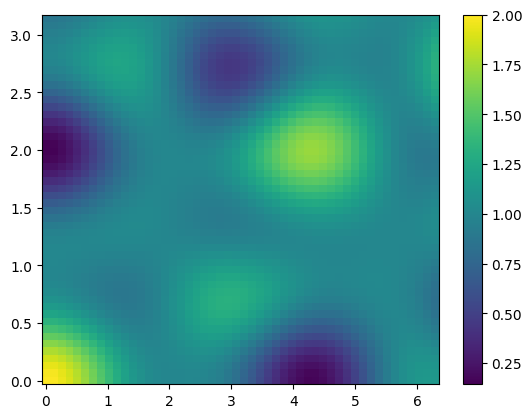

In [3]:
def dummy_antenna_pattern(a, d):
    return 1 + (np.cos(2*a/3)**2 - np.sin(5*d/3)**2)*np.cos(5*a/6)*np.cos(4*d/3)

def mchirp(m1, m2):
    return (m1 * m2)**(3/5) / (m1 + m2)**(1/5)

def snr(m1, m2, dL, alpha, delta):
    return 1/dL * mchirp(m1, m2)**2.2 * dummy_antenna_pattern(alpha, delta)

av, dv = np.meshgrid(np.linspace(0,2*np.pi), np.linspace(0, np.pi))
Z = dummy_antenna_pattern(av, dv)
plt.pcolormesh(av, dv, Z)
plt.colorbar()

We're going to consider masses in the range [1, 100] $M_\odot$, angles in the range $[0, 2 \pi]$ and $[0, \pi]$ for $\alpha$ and $\delta$ respectively and $d_L$ in the range $[1, 100]$ (in some arbitrary units). 

Let's generate a dataset of SNRs in this prior range, and our neural network to be trained on these SNRs. As SNR scales inversely with luminosity distance (which is obviously true for our analytic example, but is also true in general), we can factorise this out and train on the remaining parameters.

In [93]:
n_train = int(1e6)  # number of training examples

# sample from our priors
m1 = np.random.uniform(1, 100, n_train)
m2 = np.random.uniform(1, 100, n_train)
dL = np.random.uniform(0.01, 1, n_train)
alpha = np.random.uniform(0, 2*np.pi, n_train)
delta = np.random.uniform(0, 2*np.pi, n_train)

true_snrs = snr(m1, m2, dL , alpha, delta)
xdata = torch.as_tensor(np.vstack((m1, m2, alpha, delta)).T, device=device).float()
ydata = torch.as_tensor(true_snrs * dL, device=device).float()

In [94]:
# define a rescaler, which handles the scaling of input data to facilitate training
rescaler = ZScoreRescaler(xdata, ydata)

In [95]:
# define the neural network
model = LinearModel(
    in_features=4,
    out_features=1,
    neurons=[128, 128, 128,],
    activation=torch.nn.ReLU,
    rescaler=rescaler
)

model.to(device)

LinearModel(
  (layers): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [ ]:
train_up_to = int(0.9 * n_train)
xtrain = xdata[:train_up_to,:]
ytrain = ydata[:train_up_to]
xtest = xdata[train_up_to:,:]
ytest = ydata[train_up_to:]

optimiser = torch.optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
train(
    model, 
    data=[xtrain, ytrain, xtest, ytest], 
    n_epochs=10000, 
    n_batches=1, 
    loss_function=torch.nn.MSELoss(),
    optimiser=optimiser,
    update_every=100,
    verbose=True,
)

Epoch: 9999 | Train loss: 2.682e-03 | Test loss: 2.705e-03 (Lowest: 2.705e-03)
Training complete - saving.


In [ ]:
n_train = int(1e5)
m1 = np.random.uniform(1, 100, n_train)
m2 = np.random.uniform(1, 100, n_train)
dL = np.random.uniform(0.01, 1, n_train)
alpha = np.random.uniform(0, 2*np.pi, n_train)
delta = np.random.uniform(0, 2*np.pi, n_train)

true_snrs = snr(m1, m2, dL , alpha, delta) * dL
xdata = torch.as_tensor(np.vstack((m1, m2, alpha, delta)).T, device=device).float()
ydata = torch.as_tensor(true_snrs, device=device).float()

In [ ]:
# pred = model.run_on_dataset(xdata, luminosity_distances=torch.as_tensor(dL[:int(9e5)], device=device).float()).cpu().numpy()
pred = model.run_on_dataset(xdata).cpu().numpy()
actual = true_snrs# / dL